# Hyper parameter training for part 2

In [49]:
import seaborn as sns
import pandas as pd
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
%matplotlib inline


In [50]:
# cutoff
cutoff = 2


In [51]:
# import data
train_data = pd.read_csv('Training.csv')

train_data.describe(include='all')


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category
count,29189.000000,29189,29189,29189,29189,29185,29189,29184,2.918900e+04,6047.000000,600,15365,29189
unique,NaN,2,4866,27588,24102,23305,28807,21768,NaN,NaN,600,6104,6
top,NaN,True,"01 3, 2017",AA7918E9410D650A076221C7B2934A09,6E46168E5DFA83876F2E968A187B9F7A,760C63E8E5E8DC3FAA01878D37BA5678,works great,Five Stars,NaN,NaN,['https://images-na.ssl-images-amazon.com/imag...,{'Format:': ' Audio CD'},CDs
freq,NaN,22996,40,32,36,1049,25,1476,NaN,NaN,1,4296,4912
mean,2.971907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.409661e+09,7.295353,NaN,NaN,NaN
std,1.410878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.115099e+08,18.749460,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.947584e+08,2.000000,NaN,NaN,NaN
25%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.390781e+09,2.000000,NaN,NaN,NaN
50%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.439770e+09,4.000000,NaN,NaN,NaN
75%,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.476317e+09,7.000000,NaN,NaN,NaN


In [52]:
import re

# Preprocessing data


# Stop words
GENERIC_STOP_WORDS = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while',
                      'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than', 'as']

# edit summary content


def edit_summary(content):

    # step 1 - convert the text to only lower case
    content = content.lower()

    # step 2 - remove unwanted and unicode characters
    content = re.sub(
        r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", content)

    # step 3 - remove stop words
    stopwords = GENERIC_STOP_WORDS

    filtered_words = [
        word for word in content.split() if word not in stopwords]
    text = " ".join(filtered_words)

    return text


# edit review text content
def edit_review_text(content):

    # step 1 - convert the text to only lower case
    content = content.lower()

    # step 2 - remove unwanted and unicode characters
    content = re.sub(
        r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", content)

    # step 3 - remove stop words
    stopwords = GENERIC_STOP_WORDS

    filtered_words = [
        word for word in content.split() if word not in stopwords]
    text = " ".join(filtered_words)

    return text


# create categories for vote label
def assign_vote_label(i):
    if i <= 2.0:
        return 'low'
    if i > 2.0 and i <= 10.0:
        return 'medium'
    if i > 10.0 and i <= 50.0:
        return 'good'
    if i > 50.0:
        return 'high'


# preprocess
def preprocess(data):

    # filter out only important columns
    X_cols = ['reviewText', 'summary', 'verified', 'vote', 'category']

    # editing text of "reviewText" & "summary"
    data['reviewText'] = data['reviewText'].astype(str).apply(
        edit_review_text)
    data['summary'] = data['summary'].astype(str).apply(edit_summary)

    # editing vote - assigning NAN values to 0
    data['vote'] = data['vote'].fillna(0)
    data['vote'] = data['vote'].apply(lambda x: assign_vote_label(x))

    X = train_data[X_cols]

    return X


In [53]:

# creating X and y data

# creating y labels less than cutoff to be 0 and 1 otherwise
y = train_data['overall'].apply(lambda x: 0 if x <= cutoff else 1)

# create features data
X = preprocess(train_data)


In [54]:
from sklearn.model_selection import train_test_split

# train test split function
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, random_state=101)


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score
from sklearn.exceptions import ConvergenceWarning
import warnings

# ignore warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# define the column transformer to apply TfidfVectorizer & encoder to multiple columns
ct = ColumnTransformer(
    [("vect_summary", TfidfVectorizer(), 'summary'),
     ("vect_reviewText", TfidfVectorizer(), 'reviewText'),
     ("encd_verified", OrdinalEncoder(dtype=int), ['verified']),
     ("encd_category", OrdinalEncoder(dtype=int), ['category']),
     ("encd_votes", OrdinalEncoder(dtype=int), ['vote'])
     ])

# For results
model_arr, auc_arr, f1_arr, accuracy_arr = [], [], [], []


# Logistic Regression

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START classifier__C=0.1, classifier__max_iter=100, classifier__solver=liblinear, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2)
[CV 1/5; 1/48] END classifier__C=0.1, classifier__max_iter=100, classifier__solver=liblinear, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2);, score=0.819 total time=   4.7s
[CV 2/5; 1/48] START classifier__C=0.1, classifier__max_iter=100, classifier__solver=liblinear, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2)
[CV 2/5; 1/48] END classifier__C=0.1, class

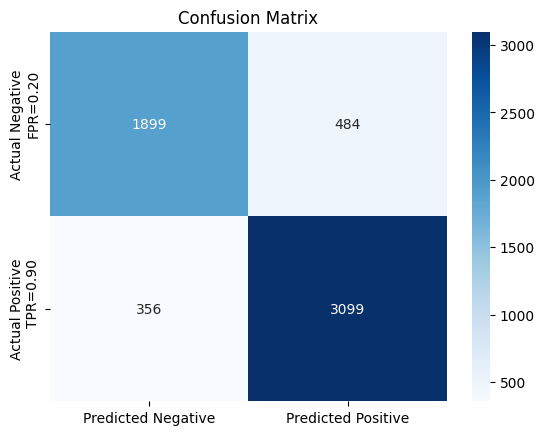

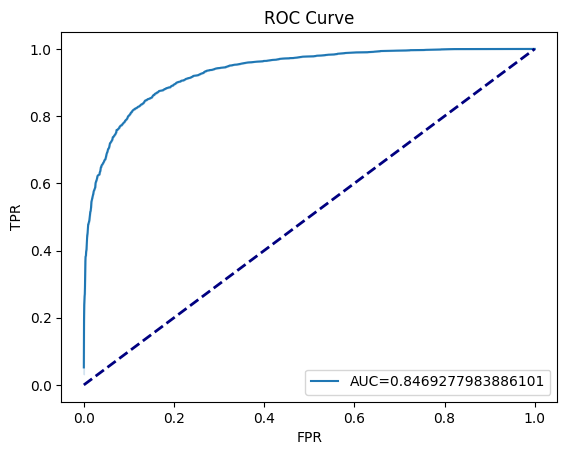

In [56]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("transformer", ct),
    ("classifier", LogisticRegression())
])

params = {
    "transformer__vect_summary__ngram_range": [(1, 2)],
    "transformer__vect_reviewText__ngram_range": [(1, 2)],
    "transformer__vect_summary__max_features": [10000, 32000],
    "transformer__vect_reviewText__max_features": [5000, 10000],
    "classifier__solver": ['liblinear'],
    "classifier__C": [0.1, 1.0, 5.0, 10.0],
    "classifier__max_iter": [100, 500, 1000]
}


# perform grid search cross-validation to find the best hyperparameters
grid_log = GridSearchCV(pipe, params, cv=5, scoring='f1_macro', verbose=10)

grid_log.fit(X_train, y_train)
print("-----------------------------------------------------------------------------------------------------------------------------------")
print("Best: %f using %s" % (grid_log.best_score_, grid_log.best_params_))

# predict
y_pred_log = grid_log.best_estimator_.predict(X_test)

# f1 score
fscore = f1_score(y_test, y_pred_log, average='macro')
print("f1_score: ", fscore)
f1_arr.append(fscore)

# accuracy
accur = accuracy_score(y_test, y_pred_log)
accuracy_arr.append(accur)
print("accuracy: ", accur)

# auc score
aucscore = roc_auc_score(y_test, y_pred_log)
print("auc score: ", aucscore)
auc_arr.append(aucscore)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_log)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative\nFPR={:.2f}'.format(fpr), 'Actual Positive\nTPR={:.2f}'.format(tpr)])
plt.title("Confusion Matrix")
plt.show()

# ROC curve
y_pred_prob_log = grid_log.best_estimator_.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob_log[:,1])
sns.lineplot(x=fpr, y=tpr,label="AUC="+str(aucscore))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

model_arr.append("Logistic Regression")


# Multinomial Naive Bayes

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START classifier__alpha=0.01, classifier__fit_prior=True, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2)
[CV 1/5; 1/40] END classifier__alpha=0.01, classifier__fit_prior=True, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2);, score=0.803 total time=   3.3s
[CV 2/5; 1/40] START classifier__alpha=0.01, classifier__fit_prior=True, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2)
[CV 2/5; 1/40] END classifier__alpha=0.01, classifier__fit_prior=True, transformer__vect_reviewText__max_feature

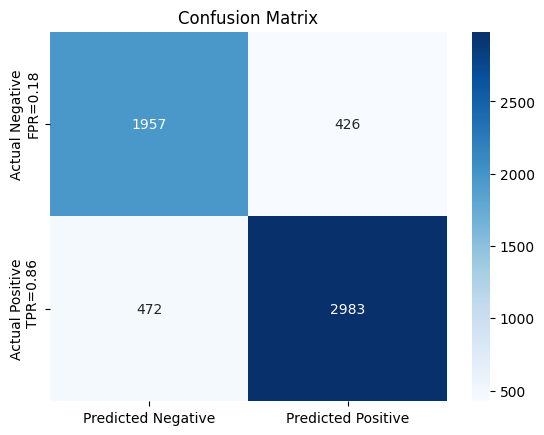

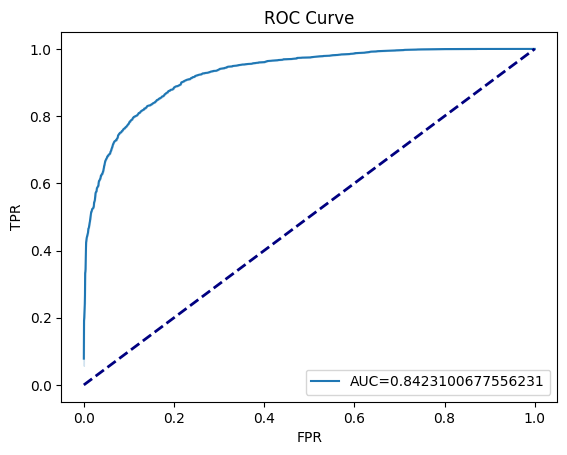

In [57]:
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline([
    ("transformer", ct),
    ("classifier", MultinomialNB())
])

mnbModel_params = {
    "transformer__vect_summary__ngram_range": [(1, 2)],
    "transformer__vect_reviewText__ngram_range": [(1, 2)],
    "transformer__vect_summary__max_features": [10000, 32000],
    "transformer__vect_reviewText__max_features": [5000, 10000],
    "classifier__alpha": [0.01, 0.1, 0.5, 1, 10],
    'classifier__fit_prior': [True, False],
}


# perform grid search cross-validation to find the best hyperparameters
grid_mnb = GridSearchCV(pipe, mnbModel_params, cv=5, scoring='f1_macro', verbose=10)

grid_mnb.fit(X_train, y_train)
print("Best: %f using %s" % (grid_mnb.best_score_, grid_mnb.best_params_))

# predict
y_pred_mnb = grid_mnb.best_estimator_.predict(X_test)

# f1 score
fscore = f1_score(y_test, y_pred_mnb, average='macro')
print("f1_score: ", fscore)
f1_arr.append(fscore)

# accuracy
accur = accuracy_score(y_test, y_pred_mnb)
accuracy_arr.append(accur)
print("accuracy: ", accur)

# auc score
aucscore = roc_auc_score(y_test, y_pred_mnb)
print("auc score: ", aucscore)
auc_arr.append(aucscore)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_mnb)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative\nFPR={:.2f}'.format(fpr), 'Actual Positive\nTPR={:.2f}'.format(tpr)])
plt.title("Confusion Matrix")
plt.show()

# ROC curve
y_pred_prob_mnb = grid_mnb.best_estimator_.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob_mnb[:,1])
sns.lineplot(x=fpr, y=tpr,label="AUC="+str(aucscore))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

model_arr.append("MultinomialNB")


# SVC

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START classifier__estimator__C=10, classifier__estimator__penalty=l1, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2)
[CV 1/5; 1/32] END classifier__estimator__C=10, classifier__estimator__penalty=l1, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2);, score=nan total time=   2.2s
[CV 2/5; 1/32] START classifier__estimator__C=10, classifier__estimator__penalty=l1, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2)
[CV 2/5; 1/32] END classifier__estimator__C=10, classifier__estimator__penalty

/Users/shyamreddy/.pyenv/versions/3.9.2/envs/mlenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/shyamreddy/.pyenv/versions/3.9.2/envs/mlenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shyamreddy/.pyenv/versions/3.9.2/envs/mlenv/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/shyamreddy/.pyenv/versions/3.9.2/en

-----------------------------------------------------------------------------------------------------------------------------------
Best: 0.846307 using {'classifier__estimator__C': 0.1, 'classifier__estimator__penalty': 'l2', 'transformer__vect_reviewText__max_features': 10000, 'transformer__vect_reviewText__ngram_range': (1, 2), 'transformer__vect_summary__max_features': 32000, 'transformer__vect_summary__ngram_range': (1, 2)}
f1_score:  0.8508080372339801
accuracy:  0.8568002740664611
auc score:  0.8486133994229507


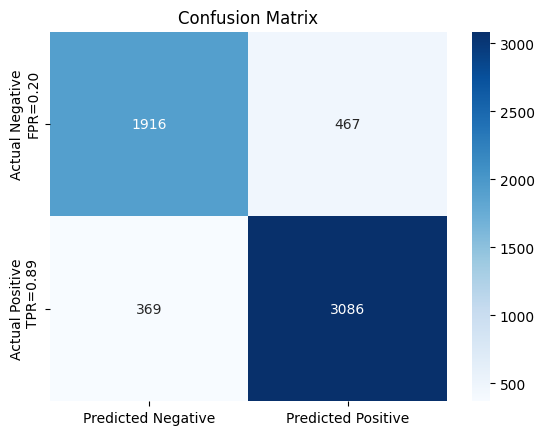

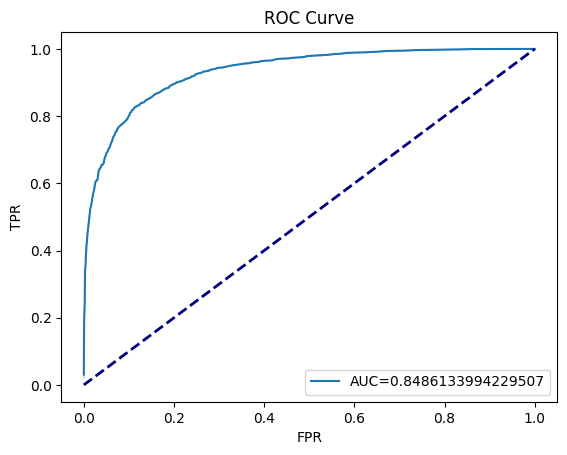

In [58]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

pipe = Pipeline([
    ("transformer", ct),
    ("classifier", CalibratedClassifierCV(estimator = LinearSVC()))
])

svcModel_params = {
    "transformer__vect_summary__ngram_range": [(1, 2)],
    "transformer__vect_reviewText__ngram_range": [(1, 2)],
    "transformer__vect_summary__max_features": [10000, 32000],
    "transformer__vect_reviewText__max_features": [5000, 10000],
    "classifier__estimator__C": [10, 1, 0.1, 0.01],
    "classifier__estimator__penalty": ['l1', 'l2'],
}


# perform grid search cross-validation to find the best hyperparameters
grid_svc = GridSearchCV(pipe, svcModel_params, cv=5, scoring='f1_macro', verbose=10)

grid_svc.fit(X_train, y_train)
print("-----------------------------------------------------------------------------------------------------------------------------------")
print("Best: %f using %s" % (grid_svc.best_score_, grid_svc.best_params_))

# predict
y_pred_svc = grid_svc.best_estimator_.predict(X_test)

# f1 score
fscore = f1_score(y_test, y_pred_svc, average='macro')
print("f1_score: ", fscore)
f1_arr.append(fscore)

# accuracy
accur = accuracy_score(y_test, y_pred_svc)
accuracy_arr.append(accur)
print("accuracy: ", accur)

# auc score
aucscore = roc_auc_score(y_test, y_pred_svc)
print("auc score: ", aucscore)
auc_arr.append(aucscore)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative\nFPR={:.2f}'.format(fpr), 'Actual Positive\nTPR={:.2f}'.format(tpr)])
plt.title("Confusion Matrix")
plt.show()

# ROC curve
y_pred_prob_svc = grid_svc.best_estimator_.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob_svc[:, 1])
sns.lineplot(x=fpr, y=tpr, label="AUC="+str(aucscore))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

model_arr.append("LinearSVC")


# SGD Classifier

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START classifier__estimator__alpha=0.001, classifier__estimator__loss=hinge, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2)
[CV 1/5; 1/32] END classifier__estimator__alpha=0.001, classifier__estimator__loss=hinge, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2);, score=0.830 total time=   2.9s
[CV 2/5; 1/32] START classifier__estimator__alpha=0.001, classifier__estimator__loss=hinge, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2)
[CV 2/5; 1/32] END classifier__estimator__alpha=0.001, 

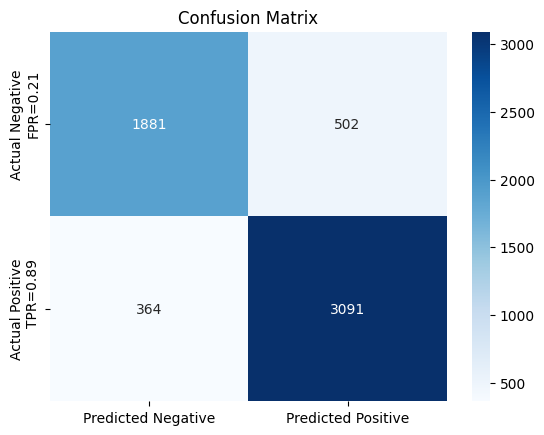

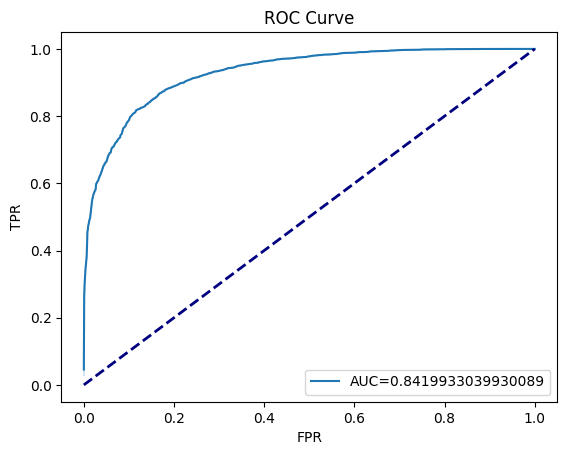

In [59]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

pipe = Pipeline([
    ("transformer", ct),
    ("classifier", CalibratedClassifierCV(estimator=SGDClassifier()))
])

sgd_params = {
    "transformer__vect_summary__ngram_range": [(1, 2)],
    "transformer__vect_reviewText__ngram_range": [(1, 2)],
    "transformer__vect_summary__max_features": [10000, 32000],
    "transformer__vect_reviewText__max_features": [5000, 10000],
    "classifier__estimator__alpha": [0.001, 0.01, 0.1, 1],
    "classifier__estimator__loss": ['hinge', 'perceptron'],
}


# perform grid search cross-validation to find the best hyperparameters
grid_sgd = GridSearchCV(pipe, sgd_params, cv=5, scoring='f1_macro', verbose=10)

grid_sgd.fit(X_train, y_train)
print("-----------------------------------------------------------------------------------------------------------------------------------")
print("Best: %f using %s" % (grid_sgd.best_score_, grid_sgd.best_params_))

# predict
y_pred_sgd = grid_sgd.best_estimator_.predict(X_test)

# f1 score
fscore = f1_score(y_test, y_pred_sgd, average='macro')
print("f1_score: ", fscore)
f1_arr.append(fscore)

# accuracy
accur = accuracy_score(y_test, y_pred_sgd)
accuracy_arr.append(accur)
print("accuracy: ", accur)

# auc score
aucscore = roc_auc_score(y_test, y_pred_sgd)
print("auc score: ", aucscore)
auc_arr.append(aucscore)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_sgd)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative\nFPR={:.2f}'.format(fpr), 'Actual Positive\nTPR={:.2f}'.format(tpr)])
plt.title("Confusion Matrix")
plt.show()

# ROC curve
y_pred_prob_sgd = grid_sgd.best_estimator_.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob_sgd[:, 1])
sns.lineplot(x=fpr, y=tpr, label="AUC="+str(aucscore))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

model_arr.append("Stochastic Gradient classifier")


In [60]:
pd.DataFrame({"Model": model_arr, "auc": auc_arr,
              "f1 score": f1_arr, "Accuracy": accuracy_arr, }).head()


,Model,auc,f1 score,Accuracy
0,Logistic Regression,0.846928,0.849768,0.856115
1,MultinomialNB,0.842310,0.841278,0.846180
2,LinearSVC,0.848613,0.850808,0.856800
3,Stochastic Gradient classifier,0.841993,0.845003,0.851662
